## Reduce a S1 datacube along temporal axis to a raster

In [1]:
import numpy as np
import os, osr, glob
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd
# import TUW packages
from yeoda.products.preprocessed import SIG0DataCube
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename

Specify the folder with a S1 datacube (a 300x300 m<sup>2</sup> Equi7Tile)

In [2]:
#tile_dirpath = r'/project/return/Share/EODC_SA020M/V01R01/E051N060T3'
tile_dirpath = r'/project/return/Share/EODC_SA020M/V01R01/E078N066T3'
# specify other parameters:
dimensions=['time', 'band', 'extra_field', 'sensor_field']
filepaths = glob.glob(os.path.join(tile_dirpath,'*.tif'))

Read the datacube:

In [3]:
sig0_dc = SIG0DataCube(filepaths=filepaths, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
# get info:
sig0_dc.inventory[dimensions].head(5)

,time,band,extra_field,sensor_field,var_name,tile_name
0,2019-09-24 09:22:59,VH,D039,S1AIWGRDH,SIG0,E078N066T3
1,2020-11-18 09:14:33,VH,D141,S1B,SIG0,E078N066T3
2,2020-06-21 09:15:13,VV,D141,S1A,SIG0,E078N066T3
3,2019-02-03 09:14:37,VV,D141,S1AIWGRDH,SIG0,E078N066T3
4,2019-02-08 09:23:15,VH,D039,S1AIWGRDH,SIG0,E078N066T3


Filter by date:

In [4]:
toi_start, toi_end = datetime(2017, 1, 1), datetime(2022, 1, 1)
sig0_dc.filter_by_dimension([(toi_start, toi_end)], [(">", "<")], name="time", inplace=True)

                                              filepath                time  \
0    /project/return/Share/EODC_SA020M/V01R01/E078N... 2019-09-24 09:22:59   
1    /project/return/Share/EODC_SA020M/V01R01/E078N... 2020-11-18 09:14:33   
2    /project/return/Share/EODC_SA020M/V01R01/E078N... 2020-06-21 09:15:13   
3    /project/return/Share/EODC_SA020M/V01R01/E078N... 2019-02-03 09:14:37   
4    /project/return/Share/EODC_SA020M/V01R01/E078N... 2019-02-08 09:23:15   
..                                                 ...                 ...   
941  /project/return/Share/EODC_SA020M/V01R01/E078N... 2020-04-03 09:22:32   
942  /project/return/Share/EODC_SA020M/V01R01/E078N... 2020-06-09 09:15:12   
943  /project/return/Share/EODC_SA020M/V01R01/E078N... 2020-10-21 22:05:48   
944  /project/return/Share/EODC_SA020M/V01R01/E078N... 2020-08-20 09:14:26   
945  /project/return/Share/EODC_SA020M/V01R01/E078N... 2020-02-03 09:23:22   

    band extra_field sensor_field var_name   tile_name  
0     

Select bands:

In [5]:
sig0_vv_dc = sig0_dc.filter_by_dimension('VV', name='band')
sig0_vh_dc = sig0_dc.filter_by_dimension('VH', name='band')

Get the datacube geomery

In [6]:
sig0_vv_dc.raster_geometry.shape

(15000, 15000)

Load data 

In [32]:
sig0_vv_dc_chunk1 = sig0_vv_dc.load_by_pixels(1000, 1000, row_size=500, col_size=50, dtype='xarray')
print(sig0_vv_dc_chunk1)

<xarray.Dataset>
Dimensions:  (time: 473, y: 50, x: 50)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-21T09:15:13 ... 2020-06-09T09:15:12
  * y        (y) float64 6.88e+06 6.88e+06 6.88e+06 ... 6.879e+06 6.879e+06
  * x        (x) float64 7.82e+06 7.82e+06 7.82e+06 ... 7.821e+06 7.821e+06
Data variables:
    1        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan


Get the in-memory size 

In [33]:
print('Datacube size in memory is:', np.round(sig0_vv_dc_chunk1.nbytes/(1024*1024), 1), 'MB')

Datacube size in memory is: 9.0 MB


Rename the variavle

In [34]:
sig0_vv_dc_chunk1 = sig0_vv_dc_chunk1.rename({'1':'sig0_vv'})

Get the mean sig0 raster

In [35]:
sig0_vv_mean = sig0_vv_dc_chunk1.mean(dim='time')
# divide the values by 100 to get dBs:
sig0_vv_mean = sig0_vv_mean/100.
#
print(sig0_vv_mean)

<xarray.Dataset>
Dimensions:  (y: 50, x: 50)
Coordinates:
  * y        (y) float64 6.88e+06 6.88e+06 6.88e+06 ... 6.879e+06 6.879e+06
  * x        (x) float64 7.82e+06 7.82e+06 7.82e+06 ... 7.821e+06 7.821e+06
Data variables:
    sig0_vv  (y, x) float64 -0.7398 -0.7362 -0.6856 ... -0.9355 -1.016 -0.9306


In [36]:
print('Raster size in memory is:', np.round(sig0_vv_mean.nbytes/(1024*1024), 1), 'MB')

Raster size in memory is: 0.0 MB


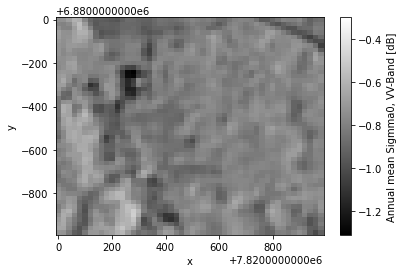

In [37]:
sig0_vv_mean.sig0_vv.plot(vmax=-0.3, cmap='gray', cbar_kwargs={'label': 'Annual mean Sigmma0, VV-Band [dB]'})

In [38]:
ds_count = sig0_vv_dc_chunk1.sig0_vv.sortby('time').groupby('time').count(dim=['x', 'y'])
print(ds_count)

<xarray.DataArray 'sig0_vv' (time: 473)>
array([2500,    0,    0,    0,    0,    0, 2500,    0,    0,    0,    0,
          0, 2500,    0,    0,    0,    0,    0, 2500,    0,    0, 2500,
          0,    0,    0,    0,    0, 2500,    0,    0,    0,    0,    0,
       2500,    0,    0,    0,    0,    0, 2500,    0,    0,    0,    0,
          0, 2500,    0,    0,    0,    0,    0, 2500,    0,    0,    0,
          0,    0, 2500,    0,    0,    0,    0,    0, 2500,    0,    0,
          0,    0,    0, 2500,    0,    0,    0,    0,    0, 2500,    0,
          0,    0,    0,    0, 2500,    0,    0,    0,    0,    0, 2500,
          0,    0,    0,    0,    0, 2500,    0,    0,    0,    0,    0,
       2500,    0,    0,    0,    0,    0,    0, 2500,    0,    0,    0,
          0,    0,    0, 2500,    0,    0,    0,    0,    0,    0, 2500,
          0,    0,    0,    0,    0,    0, 2500,    0,    0,    0,    0,
          0,    0, 2500,    0,    0,    0,    0,    0,    0, 2500,    0,
          

In [46]:
ds_count.time.min()

<xarray.DataArray 'time' ()>
array('2019-01-03T09:22:26.000000000', dtype='datetime64[ns]')

In [ ]:
ds_fullCover = ds_count.where(ds_count > 0, drop=True)
print(ds_fullCover)

In [ ]:
ds_fullCover.time

In [ ]:
montly_mean = sig0_vv_dc_chunk1.sig0_vv.sortby('time').resample(time="1M").mean()
print(montly_mean.time)